### Fit exponential to data

In [1]:
%load_ext autoreload
%autoreload 2  """Reloads all functions automatically"""

In [2]:
from irreversible_stressstrain import StressStrain as strainmodel
import test_suite as suite
import graph_suite as plot
import numpy as np
from scipy.optimize import curve_fit

model = strainmodel('ref/HSRS/22').get_experimental_data()

cur_index = 0

# deleting noisy values (possible inaccuracies up to .025)
for index, num in enumerate(model[:,0]):
    
    if num >= 0.025: 
        cur_index = index
        break
        
model = model[cur_index:]
        
# normalize values for log
for index, num in enumerate(model[:,1]):
    
    if num<=1: 
        model[index,1] = 1
        num = model[index,1]
        
    model[index,1] = np.log(num)
        
predictions = suite.predictlinear(model)

#plot.plotmult2D(model, predictions)

fit_model = suite.linfit(model)
A = -np.exp(fit_model.predict([0]))
k = -fit_model.coef_

# y = A*e^(kx) model
curve = lambda x: A*np.exp(k*x)

sample_data = suite.samplepoints(curve,[0,15],20)
    
#plot.plotmult2D(strainmodel('ref/HSRS/22').get_experimental_data(),sample_data)



/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


## We should fit with logarithmic curve, not exponential

[ 1.  1.  1.]


/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log


<IPython.core.display.Javascript object>


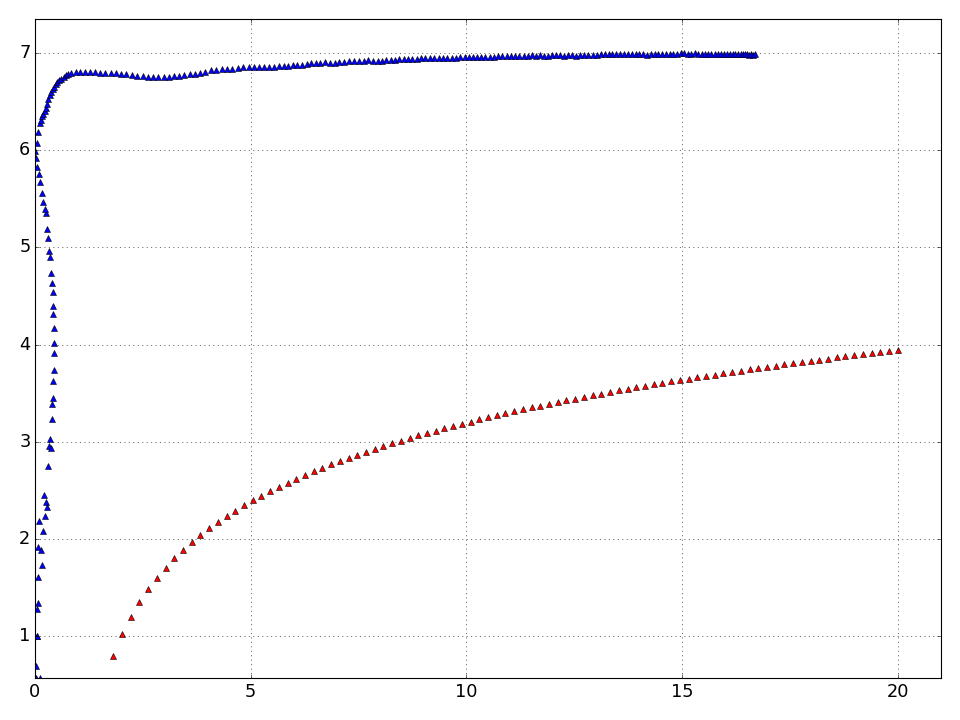

In [4]:
"""a, b, and c are parameters"""
def fit(x, a,b,c):
    return a*np.log(x-b)+c

model = suite.delete_noise(model,cutoff=0.025)
model = suite.adjust(model)

strain = model[:,0]
stress = model[:,1]

optimal_params, cov_matrix = curve_fit(fit,strain,stress)
print optimal_params

a, b, c = optimal_params

def bestfit(x):
    return a*np.log(x-b)+c

plot.plotmult2D(model,suite.samplepoints(bestfit,[0,20],100))

### We have tentatively fit a logarithmic curve to the data

[  17.15403515  978.66096801]


<IPython.core.display.Javascript object>


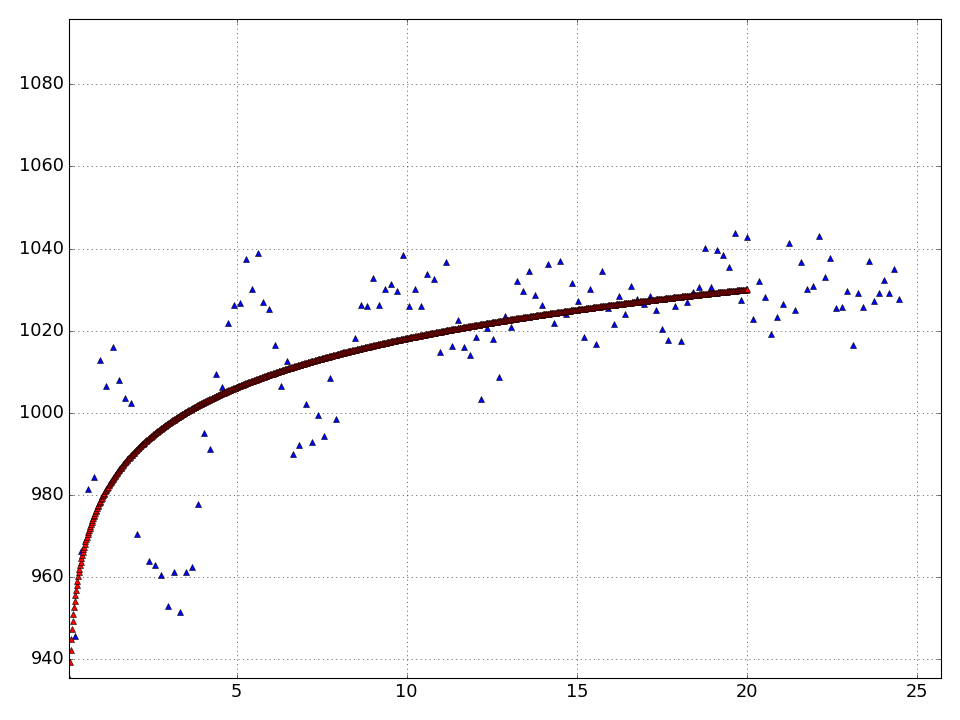

In [86]:
"""a and c are parameters"""
def fit(x, a,c):
    return a*np.log(x)+c

model = strainmodel('ref/HSRS/222').get_experimental_data()
model = suite.delete_noise(model,cutoff=0.025)
model = suite.adjust(model)

strain = model[:,0]
stress = model[:,1]

optimal_params, cov_matrix = curve_fit(fit,strain,stress)
print optimal_params

a, c = optimal_params

def bestfit(x):
    return a*np.log(x)+c

plot.plotmult2D(model,suite.samplepoints(bestfit,[0.1,20],1000))

In [87]:
vals = suite.samplepoints(bestfit,[0,20],1000)
vals[1] = suite.regularize(vals[1])

first_derivatives = suite.get_slopes(vals)
second_derivatives = suite.get_slopes(suite.combine_data(vals[:,0],first_derivatives))

second_derivatives = suite.regularize(second_derivatives)
second_derivatives = second_derivatives[1:]


class Point:
    
    def __init__(self, x, y):
        self.x = x
        self.y =y
        
    @staticmethod
    def slope_between(A,B):
        assert isinstance(A, Point)
        assert isinstance(B, Point)
        
        # technically wrong but whatever
        if(A.x==B.x):
            #raise ValueError('The two points have the same x value')
            return 0
            
        return (B.y-A.y)/(B.x-A.x) 
    
ind_current = -1
ind_max = -1

left_point = Point(strain[0],stress[0])

cur_slope = 0
max_slope = 0

while ind_current>=-len(strain)+1:
    
    if max_slope < cur_slope:
        
        max_slope = cur_slope
        ind_max = ind_current
        
    ind_current = ind_current-1

    right_point = Point(strain[ind_current],stress[ind_current])
    cur_slope = Point.slope_between(left_point,right_point)
    
print ind_max, max_slope
ind_max = len(strain)+ind_max
print ind_max

y_int = stress[ind_max] - max_slope*strain[ind_max]
print "Y intercept is", y_int

-135 83.6603050167
5
Y intercept is 929.99927162


/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


## Find domain with maximum slope

In [92]:
model = strainmodel('ref/HSRS/222').get_experimental_data()
model = suite.delete_noise(model,cutoff=0.025)
model = suite.adjust(model)

strain = model[:,0]
stress = model[:,1]

class Point:
    
    def __init__(self, x, y):
        self.x = x
        self.y =y
        
    @staticmethod
    def slope_between(A,B):
        assert isinstance(A, Point)
        assert isinstance(B, Point)
        
        # technically wrong but whatever
        if(A.x==B.x):
            #raise ValueError('The two points have the same x value')
            return 0
            
        return (B.y-A.y)/(B.x-A.x) 
    
ind_current = -1
ind_max = -1

left_point = Point(strain[0],stress[0])

cur_slope = 0
max_slope = 0

while ind_current>=-len(strain)+1:
    
    if max_slope < cur_slope:
        
        max_slope = cur_slope
        ind_max = ind_current
        
    ind_current = ind_current-1

    right_point = Point(strain[ind_current],stress[ind_current])
    cur_slope = Point.slope_between(left_point,right_point)
    
print ind_max, max_slope
ind_max = len(strain)+ind_max
print ind_max

y_int = stress[ind_max] - max_slope*strain[ind_max]
print "Y intercept is", y_int

# 2% offset line
def line_offset(x):
    return y_int + max_slope*x - 2*max_slope

-135 83.6603050167
5
Y intercept is 929.99927162


##  Searching for intersection with exponential curve

<IPython.core.display.Javascript object>


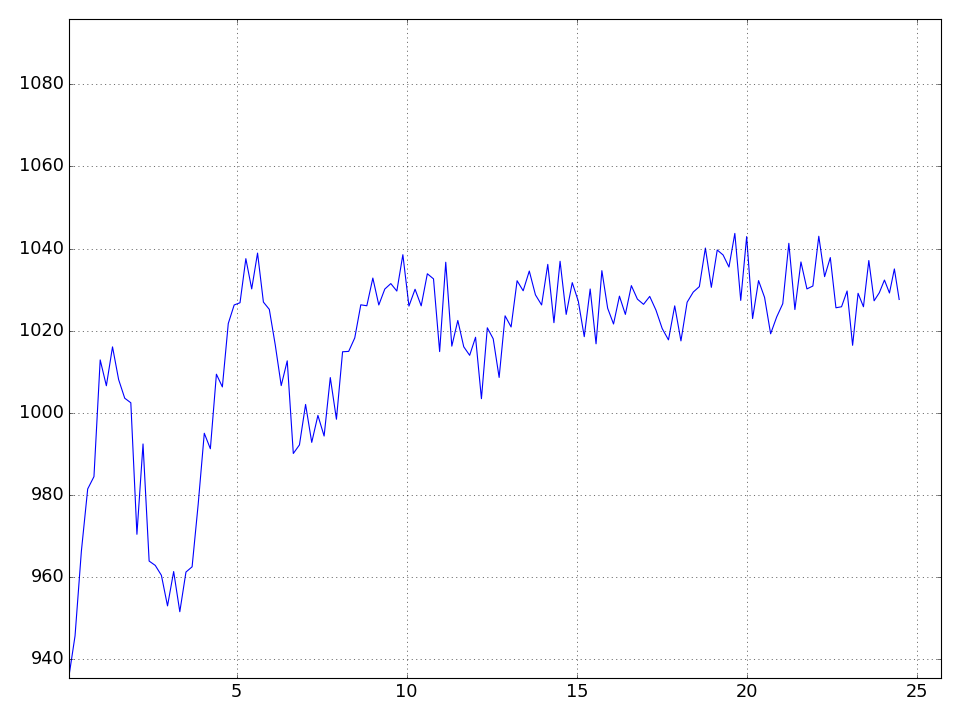

In [94]:
from scipy.optimize import fsolve
import pylab
import numpy

# x0 here is just the guess
def findIntersection(fun1,fun2,x0):
    return fsolve(lambda x : fun1(x) - fun2(x),x0)

#result = findIntersection(bestfit,line_offset,0.0)
#print result

#plot.plotmult2D(model,suite.samplepoints(bestfit,[1.,20],1000))

#plot.plotmult2D(model,suite.samplepoints(line_offset,[2.,3],1000))
#plot.plotmult2D(suite.samplepoints(bestfit,[2.,2.2],1000),suite.samplepoints(line_offset,[2.,2.2],1000))

plot.plot2D(model)

In [95]:
import math

strain = model[:,0]
stress = model[:,1]

numpoints = 1000
startx= 0.1
endx = 20.

gap_len = (endx-startx)/numpoints

xs = np.linspace(startx,endx,numpoints)
ys = bestfit(xs)

pred_data = suite.combine_data(xs,ys)
pred_slope = suite.get_slopes(pred_data)
    
ave_slope = (stress[-1]-stress[0])/(strain[-1]-strain[0])

for ind, slope in enumerate(pred_slope):
    
    if slope<ave_slope:
        print ind
        break

datapointind = ind*gap_len

for ind, stra in enumerate(model[:,0]):
    
    if stra > datapointind:
        print model[ind]
        break

Average slope is 3.78059457285
223
[    4.58197776  1006.291386  ]


## Readily evaluates yield stress on two data sets --  now we will consolidate into the module

137
[   2.74022937  855.96049394]


<IPython.core.display.Javascript object>


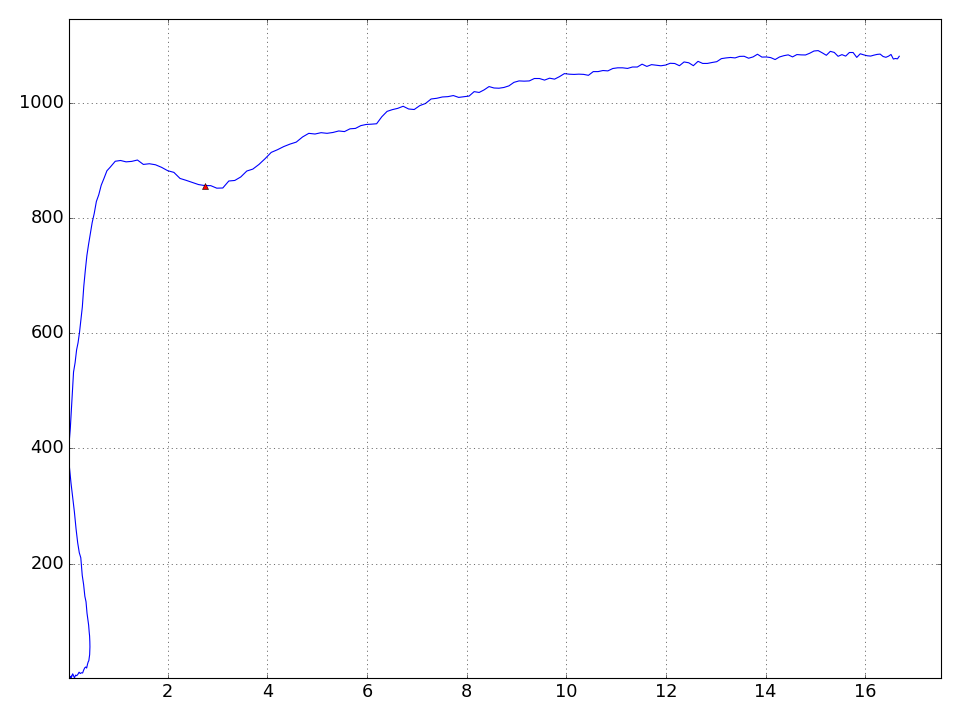

In [105]:
model = strainmodel('ref/HSRS/22').get_experimental_data()
model = suite.delete_noise(model,cutoff=0.025)
model = suite.adjust(model)

"""a and c are parameters"""
def fit(x, a,c):
    return a*np.log(x)+c

strain = model[:,0]
stress = model[:,1]

optimal_params, cov_matrix = curve_fit(fit,strain,stress)

a, c = optimal_params

"""The fitted version of the dataset"""
def bestfit(x):
    return a*np.log(x)+c

"""We look for the place where the slope is average over the dataset"""
numpoints = 1000
startx= 0.1
endx = 20.

gap_len = (endx-startx)/numpoints

xs = np.linspace(startx,endx,numpoints)
ys = bestfit(xs)

pred_data = suite.combine_data(xs,ys)
pred_slope = suite.get_slopes(pred_data)
    
ave_slope = (stress[-1]-stress[0])/(strain[-1]-strain[0])

for ind, slope in enumerate(pred_slope):
    
    if slope<ave_slope:
        print ind
        break

datapointind = ind*gap_len

for ind, stra in enumerate(model[:,0]):
    
    if stra > datapointind:
        print model[ind]
        yield_val = model[ind][None,:]
        break

plot.plotmult2D(model,yield_val, marker1='-')

[ 0.02820966  1.99673514]


<IPython.core.display.Javascript object>


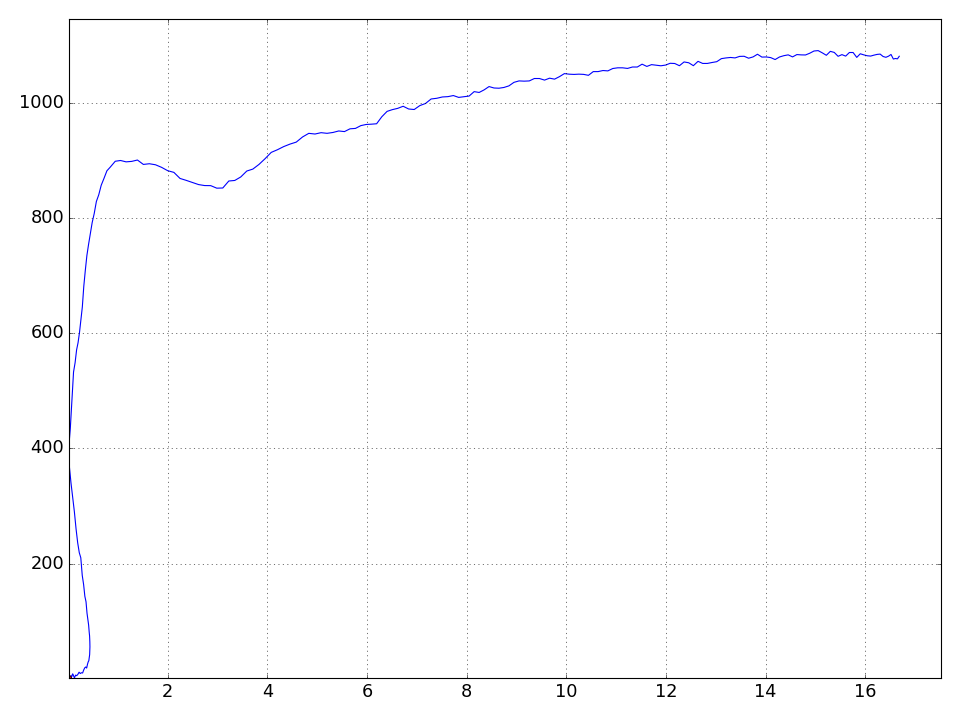

In [109]:
model = strainmodel('ref/HSRS/22').get_experimental_data()
model = suite.delete_noise(model,cutoff=0.025)
model = suite.adjust(model)

"""a and c are parameters"""
def fit(x, a,c):
    return a*np.log(x)+c

strain = model[:,0]
stress = model[:,1]

optimal_params, cov_matrix = curve_fit(fit,strain,stress)

a, c = optimal_params

"""The fitted version of the dataset"""
def bestfit(x):
    return a*np.log(x)+c

"""We look for the place where the slope is average over the dataset"""
numpoints = 1000
startx= 0.1
endx = 20.

gap_len = (endx-startx)/numpoints

xs = np.linspace(startx,endx,numpoints)
ys = bestfit(xs)

pred_data = suite.combine_data(xs,ys)
pred_slope = suite.get_slopes(pred_data)
    
ave_slope = (stress[-1]-stress[0])/(strain[-1]-strain[0])

slope = 0        
yield_ind = 0

while yield_ind<len(pred_slope) and not slope < ave_slope:
    slope = pred_slope[ind]
    yield_ind = yield_ind+1

datapointind = yield_ind*gap_len

for ind, stra in enumerate(model[:,0]):
    
    if stra > datapointind:
        print model[ind]
        yield_val = model[ind][None,:]
        break

plot.plotmult2D(model,yield_val, marker1='-')

In [3]:
print suite.yield_stress(strainmodel('ref/HSRS/22').get_experimental_data())

[[   2.74022937  855.96049394]]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


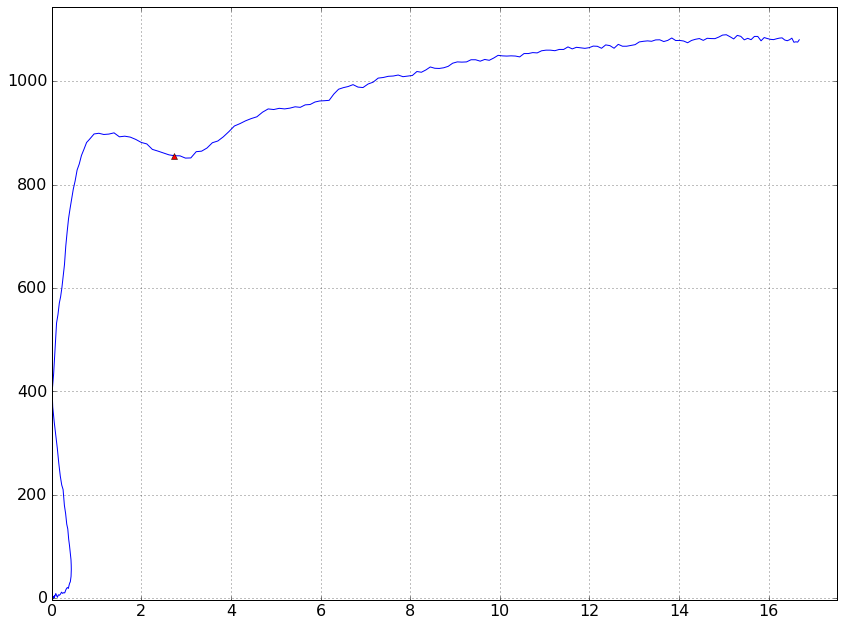

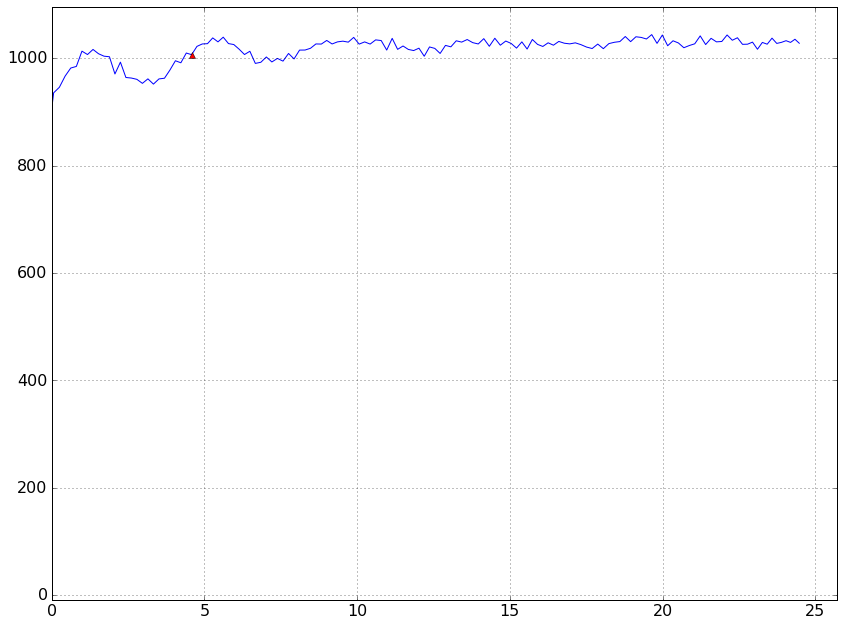

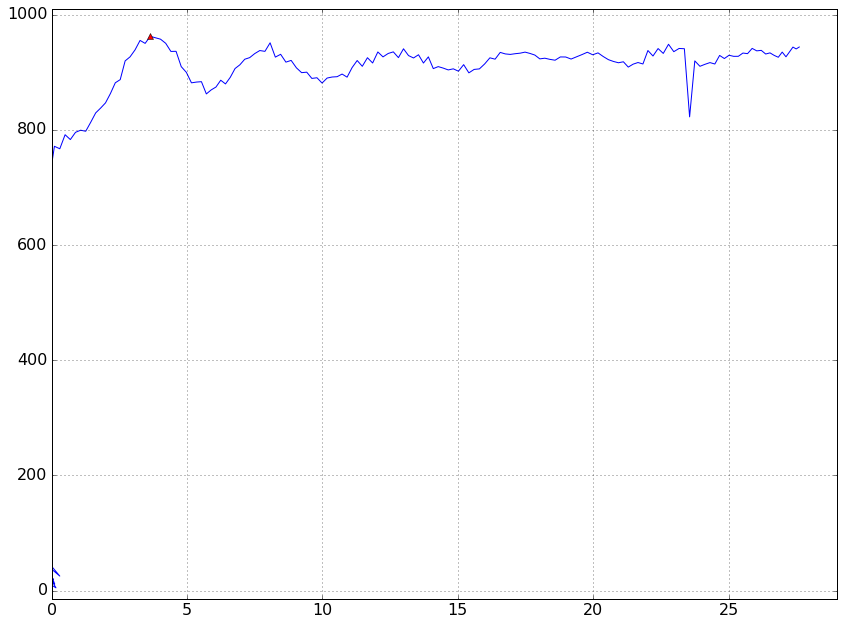

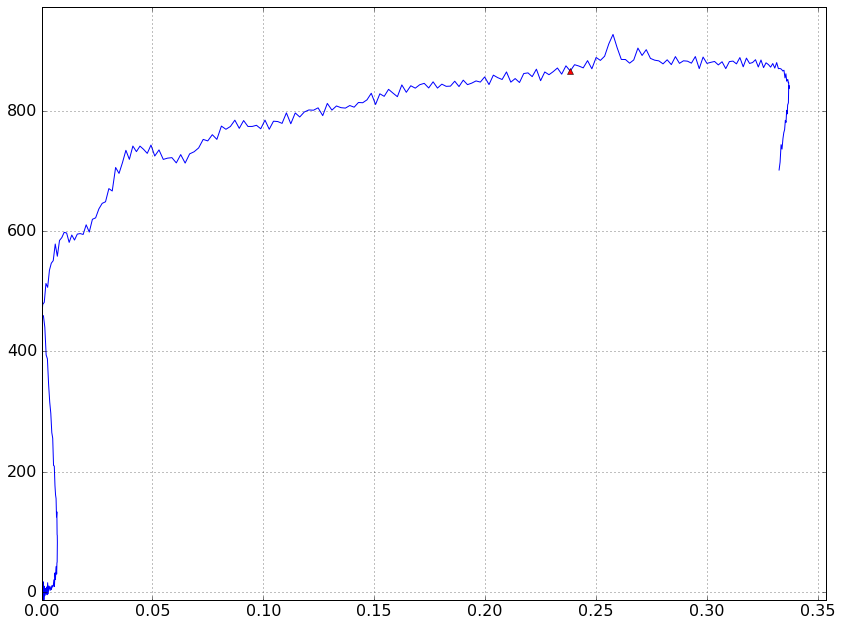

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2  """Reloads all functions automatically"""

from irreversible_stressstrain import StressStrain as strainmodel
import _test_suite_July_05_2016 as suite
import graph_suite as plot
import numpy as np
from scipy.optimize import curve_fit

data1 = strainmodel('ref/HSRS/22').get_experimental_data()
data2 = strainmodel('ref/HSRS/222').get_experimental_data()
data3 = strainmodel('ref/HSRS/326').get_experimental_data()
data4 = strainmodel('kolskybar.xml',type='xml').get_experimental_data()

yield1 = suite.yield_stress(data1)
yield2 = suite.yield_stress(data2)
yield3 = suite.yield_stress(data3, cutoff=1) # cutoff depends on noise of data
yield4 = suite.yield_stress(data4)

plot.plotmult2D(data1,yield1)
plot.plotmult2D(data2,yield2)
plot.plotmult2D(data3,yield3)
plot.plotmult2D(data4,yield4)

In [2]:
clustered1 = suite.kcluster(data1,numclusters=2)
eval1 = clustered1.predict(data1[:,0])


ValueError: the init parameter for the k-means should be 'k-means++' or 'random' or an ndarray, 'kmeans++' (type '<type 'str'>') was passed.

[[  5.70314638e-02   3.40173453e+02]] [[   12.45752013  1068.99875383]]


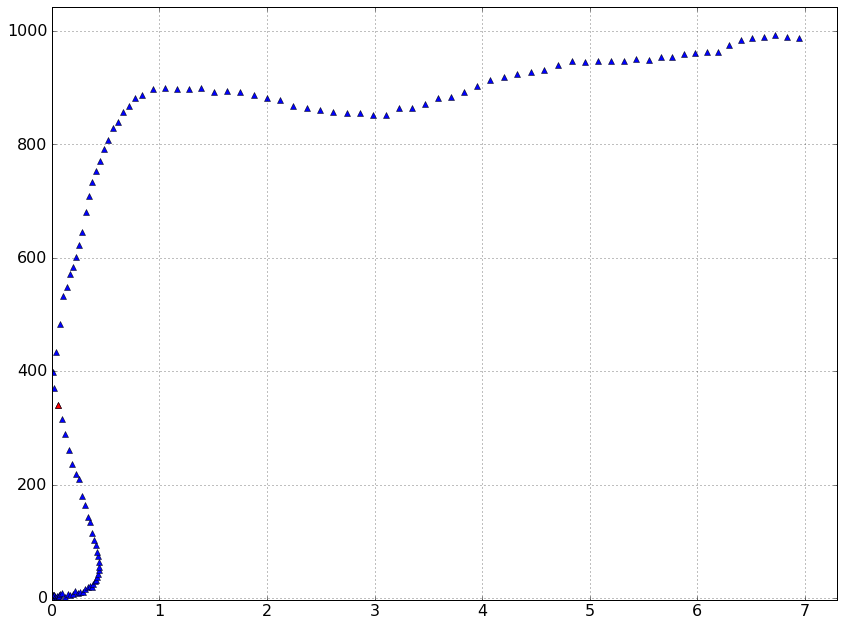

58.7739177736


In [7]:
%matplotlib inline

from sklearn.cluster import MiniBatchKMeans as mbkmeans
import test_suite
from irreversible_stressstrain import StressStrain as strainmodel
import test_suite as suite
import graph_suite as plot
import numpy as np

data1 = strainmodel('ref/HSRS/22').get_experimental_data()

# grouping into two groups and use midpoint of right part to determine slope
left, right = test_suite.splitdata(data1,test_suite.kminicluster(data1,numclusters=2).predict(data1[:,0][:,None]))
leftmid, rightmid = test_suite.midpoint(left)[None,:], test_suite.midpoint(right)[None,:]

print leftmid, rightmid
plot.plotmult2D(left,leftmid, marker1 = 'b^')

# determine slope between the two points, and use it as ave slope?
mid_slope = (rightmid[0,1]-leftmid[0,1])/(rightmid[0,0]-leftmid[0,0])
print mid_slope

In [34]:
# finds the yield stress of a dataset automatically
def yield_stress(model, numpoints=1000, cutoff=0.025, startx=None, endx=None):

    """Default interval values"""
    if startx is None:
        startx=min(model[:,0])+0.1

    if endx is None:
        endx=max(model[:,0])

    model = suite.delete_noise(model,cutoff=cutoff)
    model = suite.adjust(model)

    """a and c are parameters"""
    def fit(x, a,c):
        return a*np.log(x)+c

    strain = model[:,0]
    stress = model[:,1]

    optimal_params, cov_matrix = curve_fit(fit,strain,stress)

    a, c = optimal_params

    """The fitted version of the dataset"""
    def bestfit(x):
        return a*np.log(x)+c

    """We look for the place where the slope is average over the dataset"""
    gap_len = (endx-startx)/numpoints

    xs = np.linspace(startx,endx,numpoints)
    ys = bestfit(xs)

    pred_data = suite.combine_data(xs,ys)
    pred_slope = suite.get_slopes(pred_data)

    #ave_slope = (stress[-1]-stress[0])/(strain[-1]-strain[0])
    ave_slope = mid_slope
    
    """As soon as the slope at a point is less than the average slope, we stop"""
    for ind, slope in enumerate(pred_slope):

        if slope<ave_slope:
            break

    """
    We must take into account that we may not have a 
    data point in the experimental set where we have found a result
    """
    datapointind = ind*gap_len

    for ind, stra in enumerate(model[:,0]):

        if stra > datapointind:
            return model[ind][None,:]

    raise ValueError("The data does not seem to have a yield")
    
data1 = strainmodel('ref/HSRS/22').get_experimental_data()
data2 = strainmodel('ref/HSRS/222').get_experimental_data()
data3 = strainmodel('ref/HSRS/326').get_experimental_data()
data4 = strainmodel('kolskybar.xml',type='xml').get_experimental_data()[:,:2]

yield1 = yield_stress(data1)
yield2 = yield_stress(data2)
yield3 = yield_stress(data3,cutoff=1) # cutoff depends on noise of data
#yield4 = yield_stress(data4,cutoff=1)

# both data1 and data4 are nump.ndarrays with float64s as entries
print data1.dtype
print 
print data4.dtype

#left, right = test_suite.splitdata(data1,test_suite.kminicluster(data1,numclusters=2).predict(data1[:,0][:,None]))
#plot.plotmult2D(left,right,marker1='^')

#plot.plotmult2D(data1,yield1)
#plot.plotmult2D(data2,yield2)
#plot.plotmult2D(data3,yield3)
#plot.plotmult2D(data4,yield4)

float64

float64


/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


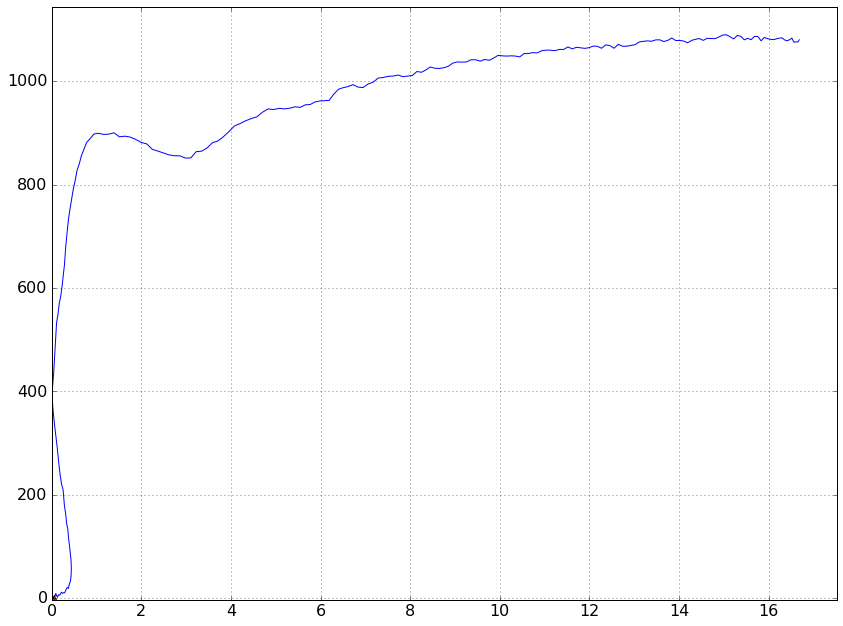

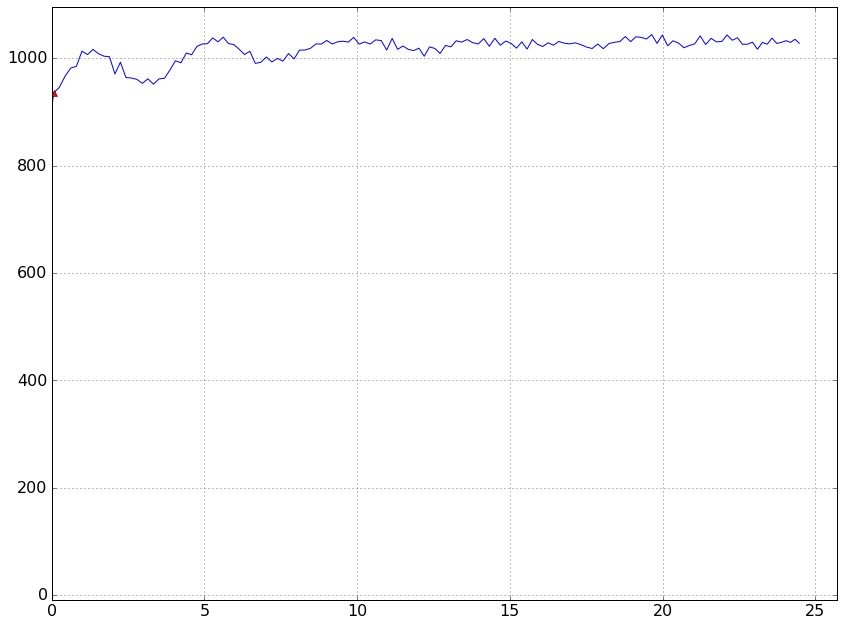

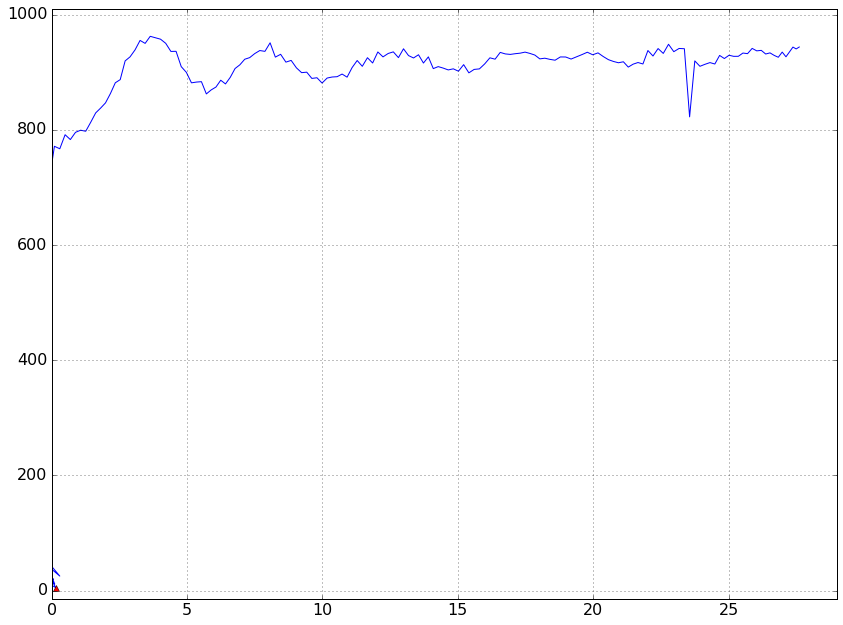

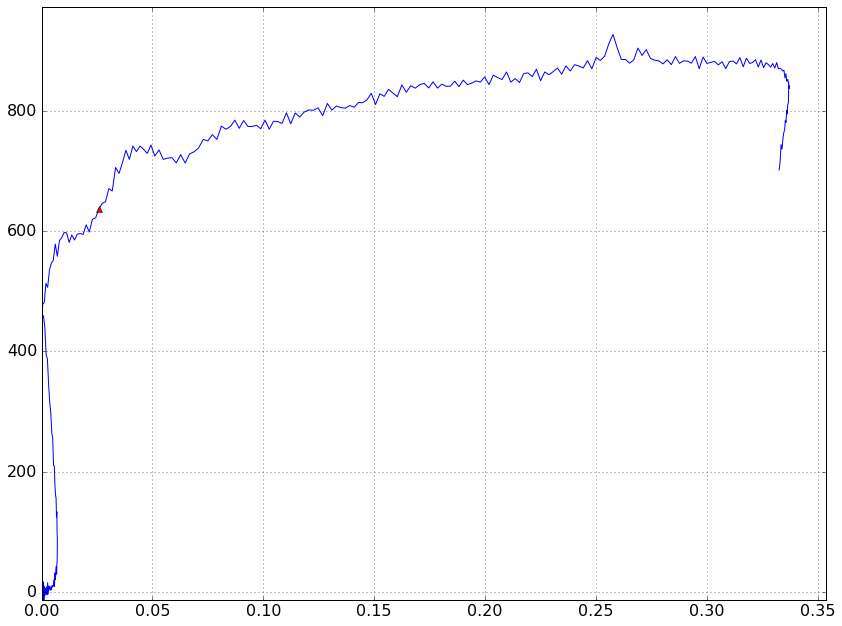

In [6]:
%autoreload 2

# finds the yield stress of a dataset automatically
def yield_stress(model, numpoints=1000, cutoff=0.025, startx=None, endx=None):

    """Default interval values"""
    if startx is None:
        startx=min(model[:,0])+0.1

    if endx is None:
        endx=max(model[:,0])

    model = suite.delete_noise(model,cutoff=cutoff)
    model = suite.adjust(model)

    """a and c are parameters"""
    def fit(x, a,c):
        return a*np.log(x)+c

    strain = model[:,0]
    stress = model[:,1]

    optimal_params, cov_matrix = curve_fit(fit,strain,stress)

    a, c = optimal_params

    """The fitted version of the dataset"""
    def bestfit(x):
        return a*np.log(x)+c

    """We look for the place where the slope is average over the dataset"""
    gap_len = (endx-startx)/numpoints

    xs = np.linspace(startx,endx,numpoints)
    ys = bestfit(xs)

    pred_data = suite.combine_data(xs,ys)
    pred_slope = suite.get_slopes(pred_data)

    """Defining average slope by observing clusters in data"""
    left, right = suite.kmeanssplit(data4)
    leftmid, rightmid = suite.midpoint(left)[None,:], suite.midpoint(right)[None,:]
    
    ave_slope = (rightmid[0,1]-leftmid[0,1])/(rightmid[0,0]-leftmid[0,0])

    
    """As soon as the slope at a point is less than the average slope, we stop"""
    for ind, slope in enumerate(pred_slope):

        if slope<ave_slope:
            break

    """
    We must take into account that we may not have a 
    data point in the experimental set where we have found a result
    """
    datapointind = ind*gap_len

    for ind, stra in enumerate(model[:,0]):

        if stra > datapointind:
            return model[ind][None,:]

    raise ValueError("The data does not seem to have a yield")
    
data1 = strainmodel('ref/HSRS/22').get_experimental_data()
data2 = strainmodel('ref/HSRS/222').get_experimental_data()
data3 = strainmodel('ref/HSRS/326').get_experimental_data()
data4 = strainmodel('kolskybar.xml',type='xml').get_experimental_data()[:,:2] # got rid of strain rate info
 
# cutoff depends on noise of data, 1 seems to work well for these measurements
yield1 = yield_stress(data1,cutoff=1.)
yield2 = yield_stress(data2)
yield3 = yield_stress(data3,cutoff=1.) 
yield4 = yield_stress(data4)

## ---- both data1 and data4 are nump.ndarrays with float64s as entries
#plot.plotmult2D(right,rightmid)
#plot.plotmult2D(left,right,marker1='^')

plot.plotmult2D(data1,yield1)
plot.plotmult2D(data2,yield2)
plot.plotmult2D(data3,yield3)
plot.plotmult2D(data4,yield4)
